In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

art = pd.read_csv("data/articles_processed.csv")            # 상품 메타데이터
cust = pd.read_csv("data/customer_processed.csv")           # 고객 메타데이터
total_revenue = pd.read_csv("data/total_revenue.csv")       # 매출 데이터

# 안전하게 날짜형 변환
total_revenue["t_dat"] = pd.to_datetime(total_revenue["t_dat"])

# 한글 폰트 설정 (맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [21]:
art.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_info',
       'product_group_name', 'graphical_appearance_info',
       'perceived_colour_master_info', 'department_info', 'index_info',
       'index_group_info', 'section_info', 'garment_group_info'],
      dtype='str')

In [22]:
cust.columns

Index(['customer_id', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'age_group'],
      dtype='str')

In [23]:
total_revenue.columns

Index(['t_dat', 'customer_id', 'article_id', 'revenue', 'sales_channel_id',
       'month', 'year_month', 'month_day', 'total_revenue', 'revenue_group'],
      dtype='str')

In [24]:
# ---------------------------------------------------------------------
# 분석용 total_revenue × customer
# 거래(매출, 날짜, 채널) + 고객 속성
# 상품은 단순 구매 대상이고 “무엇을 샀는지”는 부차적
# 어떤 고객이 매출을 만들고, 멤버십/뉴스레터는 효과가 있고 재구매 구조는 어떤한가?
# ---------------------------------------------------------------------

analysis_cust = (
    total_revenue
    .merge(cust, on="customer_id", how="inner")
)
analysis_cust.columns

Index(['t_dat', 'customer_id', 'article_id', 'revenue', 'sales_channel_id',
       'month', 'year_month', 'month_day', 'total_revenue', 'revenue_group',
       'FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'age',
       'age_group'],
      dtype='str')

In [25]:
# ---------------------------------------------------------------------
# 분석용 total_revenue × articles
# "무엇이 팔렸는가"에 집중한 데이터
# 거래(매출, 날짜, 채널) + 상품 속성
# 고객 속성이 들어가 있지 않기 떄문에 고객 차이는 관심 대상 아님
# 매출을 구성하는 상품 구조 파악 (product_type / garment_group / section / 색상군 / 외형) 
# 월별 × 상품군 판매량으로 특정 시즌에 강한 상품 / 약한 상품 파악
# 매출 상위 몇 개 상품군에 집중되어 있는지
# ---------------------------------------------------------------------

analysis_art = (
    total_revenue
    .merge(art, on="article_id", how="inner")
)
analysis_art.shape

(1037772, 21)

In [26]:
# ---------------------------------------------------------------------
# 전체 조인 (total_revenue × customer × articles)
# 볼수 있는 데이터
# 고객군별 선호 상품 연령대 × garment_group, 고객의 취향 파악 가능
# 이를 통해 타겟 전략 점검 가능 (특정 고객군이 특정 라인에 몰려 있는지)
# 가입한 사람이 아닌 소비한 고객을 골라야 하기 때문에 inner 사용
# ---------------------------------------------------------------------

analysis_master = (
    total_revenue
    .merge(cust, on="customer_id", how="inner")
    .merge(art, on="article_id", how="inner")
)
analysis_master.shape

(804149, 27)

### 누적구매율과 비중으로 확인하는 고객 분류

In [27]:
# 필요컬럼 호출
tx = analysis_cust[["customer_id", "t_dat", "year_month"]].copy()

# 날짜형 변경
tx["t_dat"] = pd.to_datetime(tx["t_dat"])


# 고객별로 날짜 순 정렬
tx = tx.sort_values(["customer_id", "t_dat"])

# 고객별 누적 구매 횟수
tx["transaction_cnt"] = (
    tx
    .groupby("customer_id")
    .cumcount() + 1
)

tx.head()

,customer_id,t_dat,year_month,transaction_cnt
77235,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2019-05-25,2019-05,1
677888,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2019-09-28,2019-09,2
696491,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2019-05-07,2019-05,1
600809,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2019-05-22,2019-05,2
522736,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2019-06-18,2019-06,3


In [28]:
tx.info()

<class 'pandas.DataFrame'>
Index: 804149 entries, 77235 to 4300
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   customer_id      804149 non-null  str           
 1   t_dat            804149 non-null  datetime64[us]
 2   year_month       804149 non-null  str           
 3   transaction_cnt  804149 non-null  int64         
dtypes: datetime64[us](1), int64(1), str(2)
memory usage: 30.7 MB


In [29]:
# 고객-월 단위로 "그 달까지 누적 구매 횟수" 만들기
# 한 달에 여러 번 사도, 그 달의 누적 상태는 max가 대표
monthly_customer = (
    tx
    .groupby(["year_month", "customer_id"], as_index=False)
    .agg(
        transaction_cnt=("transaction_cnt", "max")
    )
)

monthly_customer.head()

,year_month,customer_id,transaction_cnt
0,2019-01,00007d2de826758b65a93dd24ce629ed66842531df6699...,4
1,2019-01,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,2
2,2019-01,00023e3dd8618bc63ccad995a5ac62e21177338d642d66...,2
3,2019-01,000253f6914890557a88d0b91288ce85fae9332dac43ee...,1
4,2019-01,00025f8226be50dcab09402a2cacd520a99e112fe01fdd...,1


In [30]:
# 누적 구매횟수 기준으로 고객 유형 분류

# 신규고객 배정
monthly_customer["customer_type"] = "New"

# 재구매 고객 분류
monthly_customer.loc[
    monthly_customer["transaction_cnt"] >= 2,
    "customer_type"
] = "Repeat"

# 충성 고객 분류
monthly_customer.loc[
    monthly_customer["transaction_cnt"] >= 4,
    "customer_type"
] = "Loyal"

monthly_customer["customer_type"].value_counts()

customer_type
New       282165
Repeat    210846
Loyal     119539
Name: count, dtype: int64

In [31]:
# 월별로 고객 유형별 "고객 수" 세기
monthly_count = (
    monthly_customer
    .groupby(["year_month", "customer_type"], as_index=False)
    .agg(
        customer_cnt=("customer_id", "nunique")
    )
)


# 월별 전체 고객 수 대비 비중(%) 계산
#    월별 전체 고객 수 = customer_type별 customer_cnt 합
monthly_total = (
    monthly_count
    .groupby("year_month", as_index=False)
    .agg(
        total_cnt=("customer_cnt", "sum"))
)

# monthly_count에 monthly_total 붙여서 비중 계산하기
monthly_count =(
    monthly_count
    .merge(monthly_total, on="year_month", how="left"))

monthly_count["ratio"] = (
    monthly_count["customer_cnt"] 
    / monthly_count["total_cnt"])

In [32]:
# 누적구매율 pivot 형태로 변환
pivot_cnt = (
    monthly_count
    .pivot(
        index="year_month",
        columns="customer_type",
        values="customer_cnt"
    )
    .fillna(0)
    .sort_index()
)

pivot_cnt

customer_type,Loyal,New,Repeat
year_month,,,
2019-01,849,36928,9837
2019-02,1764,30663,11873
2019-03,3543,28977,15583
2019-04,6036,28767,19330
2019-05,8446,27546,21361
2019-06,12684,30095,26354
2019-07,14538,25846,25138
2019-08,12827,16308,17666
2019-09,14497,14751,16747


In [33]:
# 누적구매 비중 pivot 형태로 변환

pivot_ratio = (
    monthly_count
    .pivot(
            index="year_month", 
            columns="customer_type", 
            values="ratio")
    .fillna(0)
    .sort_index()
)

pivot_ratio

customer_type,Loyal,New,Repeat
year_month,,,
2019-01,0.017831,0.775570,0.206599
2019-02,0.039819,0.692167,0.268014
2019-03,0.073654,0.602395,0.323951
2019-04,0.111503,0.531413,0.357083
2019-05,0.147263,0.480289,0.372448
2019-06,0.183472,0.435320,0.381207
2019-07,0.221880,0.394463,0.383657
2019-08,0.274075,0.348454,0.377471
2019-09,0.315186,0.320709,0.364105


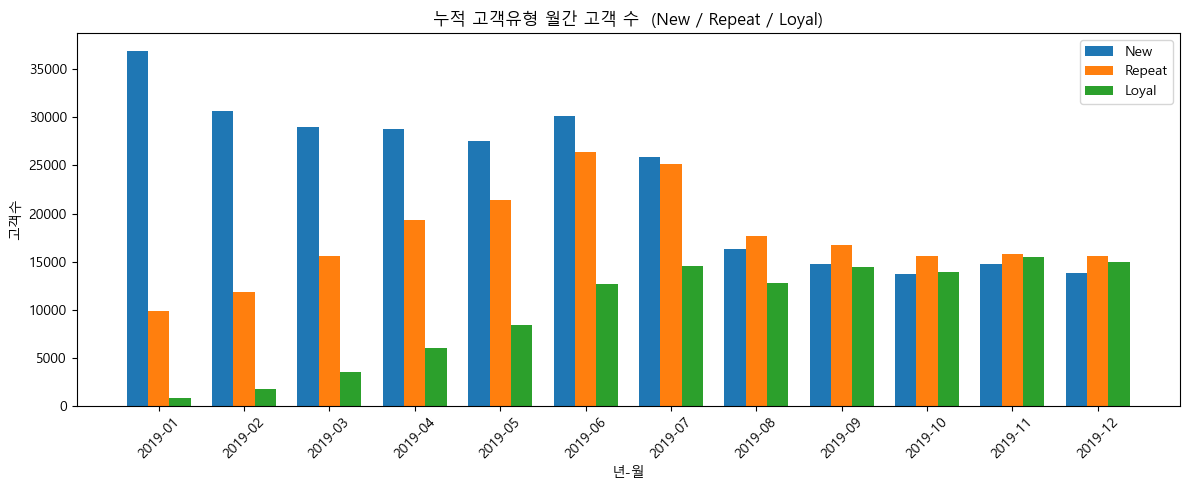

customer_type,Loyal,New,Repeat
year_month,,,
2019-01,849,36928,9837
2019-02,1764,30663,11873
2019-03,3543,28977,15583
2019-04,6036,28767,19330
2019-05,8446,27546,21361


In [34]:
x = np.arange(len(pivot_cnt.index))   # 월 위치
width = 0.25                          # 막대 너비

plt.figure(figsize=(12, 5))

plt.bar(
    x - width,
    pivot_cnt["New"],
    width=width,
    label="New"
)

plt.bar(
    x,
    pivot_cnt["Repeat"],
    width=width,
    label="Repeat"
)

plt.bar(
    x + width,
    pivot_cnt["Loyal"],
    width=width,
    label="Loyal"
)

plt.title("누적 고객유형 월간 고객 수  (New / Repeat / Loyal)")
plt.xlabel("년-월")
plt.ylabel("고객수")
plt.xticks(x, pivot_cnt.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

pivot_cnt.head()

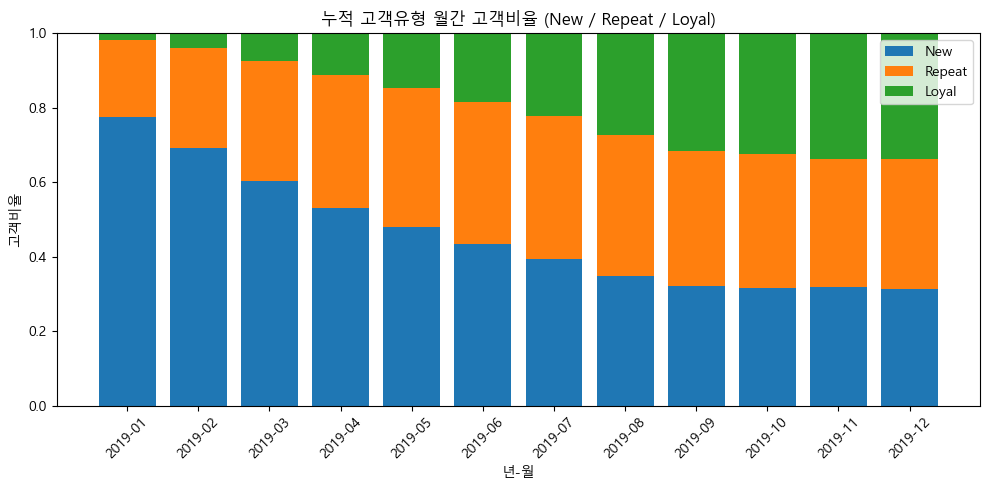

customer_type,Loyal,New,Repeat
year_month,,,
2019-01,0.017831,0.775570,0.206599
2019-02,0.039819,0.692167,0.268014
2019-03,0.073654,0.602395,0.323951
2019-04,0.111503,0.531413,0.357083
2019-05,0.147263,0.480289,0.372448
2019-06,0.183472,0.435320,0.381207
2019-07,0.221880,0.394463,0.383657
2019-08,0.274075,0.348454,0.377471
2019-09,0.315186,0.320709,0.364105


In [35]:
plt.figure(figsize=(10, 5))

plt.bar(
    pivot_ratio.index,
    pivot_ratio["New"],
    label="New"
)

plt.bar(
    pivot_ratio.index,
    pivot_ratio["Repeat"],
    bottom=pivot_ratio["New"],
    label="Repeat"
)

plt.bar(
    pivot_ratio.index,
    pivot_ratio["Loyal"],
    bottom=pivot_ratio["New"] + pivot_ratio["Repeat"],
    label="Loyal"
)

plt.title("누적 고객유형 월간 고객비율 (New / Repeat / Loyal)")
plt.xlabel("년-월")
plt.ylabel("고객비율")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

pivot_ratio

### 누적 구매율과 비중의 분석결과

> 본 분석에서는 고객의 누적 구매 횟수를 기준으로 고객 유형을 분류하였습니다. <br> 
총 구매 횟수가 2회 이상인 고객을 재구매 고객(Repeat), 4회 이상인 고객을 충성 고객(Loyal)으로 정의해 반복 구매 강도에 따른 고객 구조를 분석을 실시하였습니다.


> 본 분석은 누적 

- 시간이 지날수록 신규 고객(Normal)의 비중 감소
- 재구매 고객(Repeat)이 안정적으로 증가
- 충성 고객(Loyal, 4회 이상 구매)의 비중이 꾸준히 누적

- 신규 고객 비중은 절반 이하로 감소한다.
    - 2019-01: 77.6%
    - 2019-06: 43.5%
    - 2019-12: 31.3%
- 신규 유입이 줄었다기보다 기존 고객이 Repeat·Loyal로 이동하며 비중이 낮아진 것

- 재구매 고객
- 2019-01: 20.7%
- 2019-05: 37.2%
- 2019-08: 37.7%
- 2019-12: 35.0%

- 충성고객
- 2019-01: 1.8%
- 2019-04: 11.2%
- 2019-08: 27.4%
- 2019-12: 33.7%

> Loyal 기준을 4회 이상 구매로 잡았음에도 연말에 고객의 1/3이 충성 고객

## 누적 고객 추이 파악

### 신규고객

In [36]:
# 고객별 첫 구매 월
first_purchase = (
    tx
    .groupby("customer_id")["year_month"]
    .min()
    .reset_index(name="first_year_month")
)

# 월별 신규 고객 수
monthly_new_customers = (
    first_purchase
    .groupby("first_year_month")["customer_id"]
    .nunique()
    .reset_index(name="new_customer_cnt")
    .rename(columns={"first_year_month": "year_month"})
    .sort_values("year_month")
)

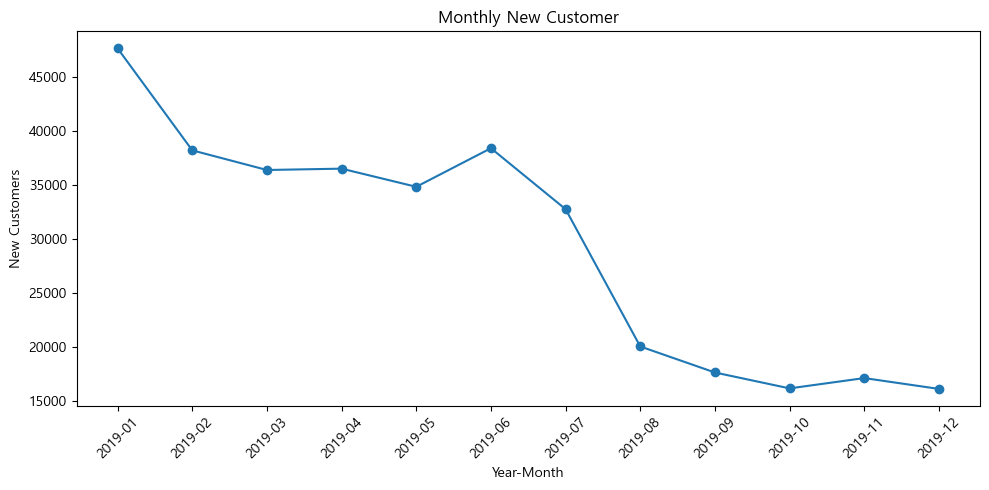

,year_month,new_customer_cnt
0,2019-01,47614
1,2019-02,38175
2,2019-03,36356
3,2019-04,36481
4,2019-05,34801
5,2019-06,38372
6,2019-07,32728
7,2019-08,20022
8,2019-09,17615
9,2019-10,16145


In [37]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(
    monthly_new_customers["year_month"],
    monthly_new_customers["new_customer_cnt"],
    marker="o",
    label="New Customers"
)

plt.title("Monthly New Customer")
plt.xlabel("Year-Month")
plt.ylabel("New Customers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

monthly_new_customers

### 재구매율

In [38]:
# 고객별 첫 구매 월
repeat_tx = tx[tx["transaction_cnt"] >= 2].copy()

# 고객별 "재구매 최초 월"
first_repeat = (
    repeat_tx
    .groupby("customer_id")["year_month"]
    .min()
    .reset_index(name="repeat_year_month")
)

# 월별 재구매 고객 유입 수
monthly_repeat_customers = (
    first_repeat
    .groupby("repeat_year_month")["customer_id"]
    .nunique()
    .reset_index(name="repeat_customer_cnt")
    .rename(columns={"repeat_year_month": "year_month"})
    .sort_values("year_month")
)

monthly_repeat_customers

,year_month,repeat_customer_cnt
0,2019-01,10686
1,2019-02,11772
2,2019-03,14755
3,2019-04,17748
4,2019-05,18917
5,2019-06,22706
6,2019-07,20793
7,2019-08,13595
8,2019-09,12347
9,2019-10,11214


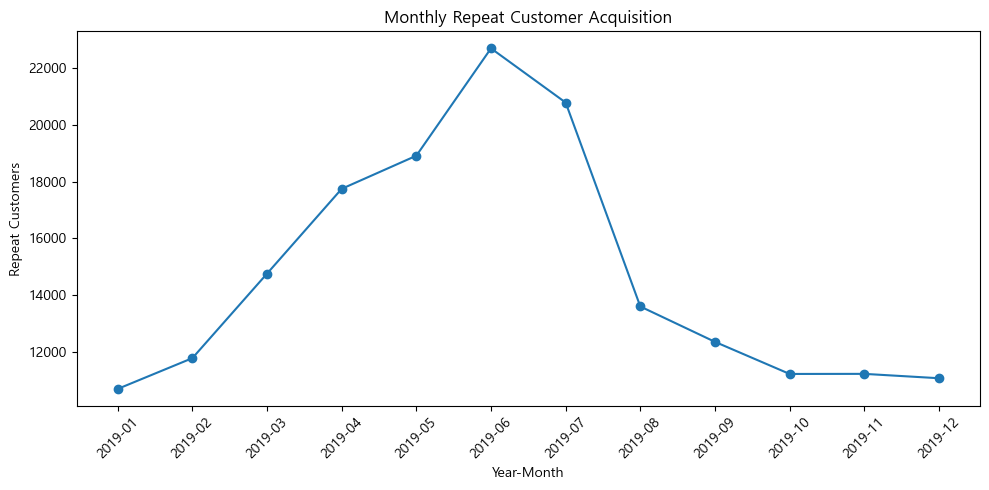

In [39]:
plt.figure(figsize=(10, 5))

plt.plot(
    monthly_repeat_customers["year_month"],
    monthly_repeat_customers["repeat_customer_cnt"],
    marker="o",
    label="Repeat (≥2)"
)

plt.title("Monthly Repeat Customer Acquisition")
plt.xlabel("Year-Month")
plt.ylabel("Repeat Customers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 충성고객

In [40]:
# 누적 구매 4회 이상이 된 거래만
loyal_tx = tx[tx["transaction_cnt"] >= 4].copy()

# 고객별 "충성 고객 최초 월"
first_loyal = (
    loyal_tx
    .groupby("customer_id")["year_month"]
    .min()
    .reset_index(name="loyal_year_month")
)

# 월별 충성 고객 유입 수
monthly_loyal_customers = (
    first_loyal
    .groupby("loyal_year_month")["customer_id"]
    .nunique()
    .reset_index(name="loyal_customer_cnt")
    .rename(columns={"loyal_year_month": "year_month"})
    .sort_values("year_month")
)

monthly_loyal_customers

,year_month,loyal_customer_cnt
0,2019-01,849
1,2019-02,1541
2,2019-03,2827
3,2019-04,4291
4,2019-05,5486
5,2019-06,7560
6,2019-07,7887
7,2019-08,5929
8,2019-09,6118
9,2019-10,5381


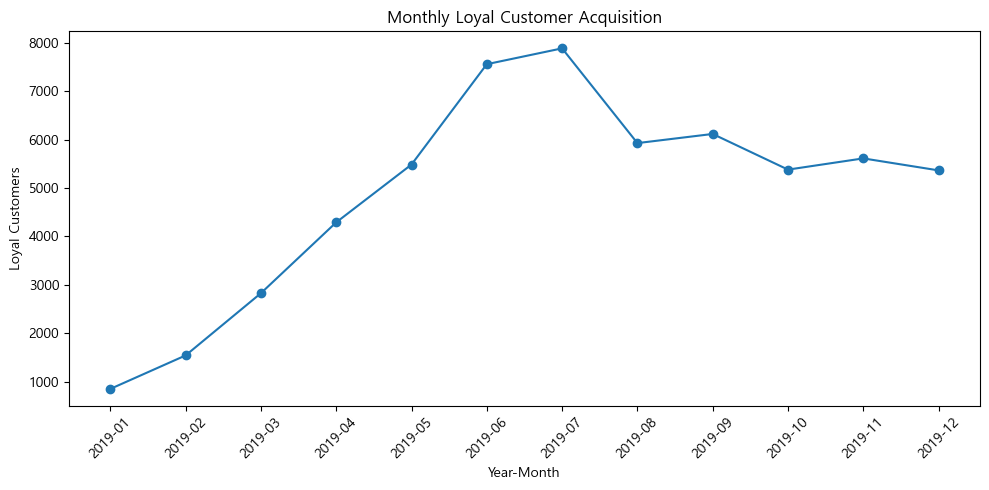

In [41]:
plt.figure(figsize=(10, 5))

plt.plot(
    monthly_loyal_customers["year_month"],
    monthly_loyal_customers["loyal_customer_cnt"],
    marker="o",
    label="Loyal (≥4)"
)

plt.title("Monthly Loyal Customer Acquisition")
plt.xlabel("Year-Month")
plt.ylabel("Loyal Customers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 누적구매율과 비중으로 확인하는 고객 속성 분석

누적 관점에서 고객을
- 신규 고객
- 재구매 고객
- 충성 고객

으로 분류하고, <br>
각 그룹이 어떤 고객 속성(age_group, FN, 멤버십 등)을 가지는지를 비중 중심으로 분석한다.

### 필요 테이블 생성
- 시간: t_dat, year_month
- 거래: revenue

- 고객 속성:
    - age_group
    - FN
    - club_member_status
    - Active

고객 매출 레벨:
    - revenue_group (top / middle / bottom)

상품군 속성:
    - 시간 되면 시도하기

In [42]:
customer_summary = (
    analysis_cust
    .sort_values("t_dat")
    .groupby("customer_id", as_index=False)
    .agg(
        # 누적 구매 횟수
        transaction_cnt=("t_dat", "size"),

        # 고객 속성 (첫 유입 시점 기준)
        age_group=("age_group", "first"),
        FN=("FN", "first"),
        club_member_status=("club_member_status", "first"),
        Active=("Active", "first"),

        # 매출 그룹 (이미 계산된 것 사용)
        revenue_group=("revenue_group", "first"),
    )
)

customer_summary.columns

Index(['customer_id', 'transaction_cnt', 'age_group', 'FN',
       'club_member_status', 'Active', 'revenue_group'],
      dtype='str')

In [43]:
customer_summary["revenue_group"].value_counts()

revenue_group
middle       209772
top_20        71027
bottom_20     70704
Name: count, dtype: int64

- 행 수가 줄어든 이유 → 거래 → 고객 단위로 바꿨기 때문

In [44]:
# 신규 / 재구매 / 충성 고객 분류
customer_summary["customer_type"] = "New"

customer_summary.loc[
    customer_summary["transaction_cnt"] >= 2,
    "customer_type"
] = "Repeat"

customer_summary.loc[
    customer_summary["transaction_cnt"] >= 4,
    "customer_type"
] = "Loyal"

customer_summary["customer_type"].value_counts()

customer_type
New       174690
Repeat    117966
Loyal      58847
Name: count, dtype: int64

## 고객 타입 x 연령대 분석

In [45]:
age_dist = (
    customer_summary
    .groupby(["customer_type", "age_group"])
    .size()
    .reset_index(name="customer_cnt")
)

age_dist["ratio"] = (
    age_dist["customer_cnt"]
    / age_dist
        .groupby("customer_type")["customer_cnt"]
        .transform("sum")
)

age_pivot = (
    age_dist
    .pivot(
        index="age_group",
        columns="customer_type",
        values="ratio"
    )
    .fillna(0)
    .sort_index()
)


<Figure size 1000x500 with 0 Axes>

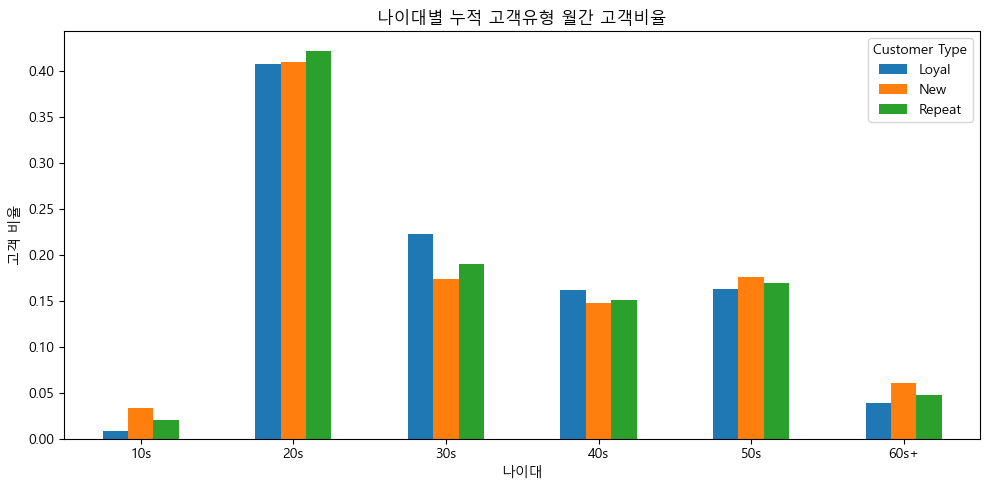

customer_type,Loyal,New,Repeat
age_group,,,
10s,0.008531,0.033013,0.020430
20s,0.406886,0.410092,0.421850
30s,0.222713,0.173290,0.189877
40s,0.161096,0.147312,0.150721
50s,0.162625,0.176112,0.169439
60s+,0.038150,0.060181,0.047683


In [46]:
plt.figure(figsize=(10, 5))

age_pivot.plot(
    kind="bar",
    figsize=(10, 5)
)

plt.title("나이대별 누적 고객유형 월간 고객비율")
plt.xlabel("나이대")
plt.ylabel("고객 비율")
plt.xticks(rotation=0)
plt.legend(title="Customer Type")
plt.tight_layout()
plt.show()

age_pivot

- 10대: 전체 비중 자체가 매우 낮고 충성 고객 비중은 거의 없음 <br>
→ 구매 지속성·충성도 형성 가능성 낮음

- 20대: 모든 고객 유형에서 가장 높은 비중 (약 40% 이상) <br>
신규 → 재구매 → 충성으로 갈수록 큰 변화 없음
> 유입의 중심 연령대. 단, 20대라고 해서 자동으로 충성 고객이 되는 구조는 아니기에 “전환 전략”이 중요하다

- 30대: 신규 고객 대비 재구매·충성 고객에서 비중이 더 높음. 특히 충성 고객이 가장 큰 비중을 차지한다.
> 충성 고객 전환 가능성이 높은 핵심 연령대로 장기 고객 가치가 크다 볼수 있다.

## 고객특성별 분석

In [47]:
# 타겟 고객군 필터링
target_2030 = customer_summary[
    customer_summary["age_group"].isin(["20s", "30s"])
].copy()

target_2030.shape

(211124, 8)

#### 고객 타입 X 특정 나이대(20~30대) X FN

In [48]:
fn_dist = (
    target_2030
    .groupby(["age_group", "customer_type", "FN"])
    .size()
    .reset_index(name="customer_cnt")
)
# 20~30대 중에서 이 고객 타입에서
# FN=True / False 고객이 몇 명?

fn_dist["ratio"] = (
    fn_dist["customer_cnt"]
    / fn_dist
        .groupby(["age_group", "customer_type"])["customer_cnt"]
        .transform("sum")
)

fn_pivot = (
    fn_dist
    .pivot(
        index=["age_group", "customer_type"],
        columns="FN",
        values="ratio"
    )
    .fillna(0)
)
fn_20s = fn_pivot.loc["20s"]
fn_30s = fn_pivot.loc["30s"]

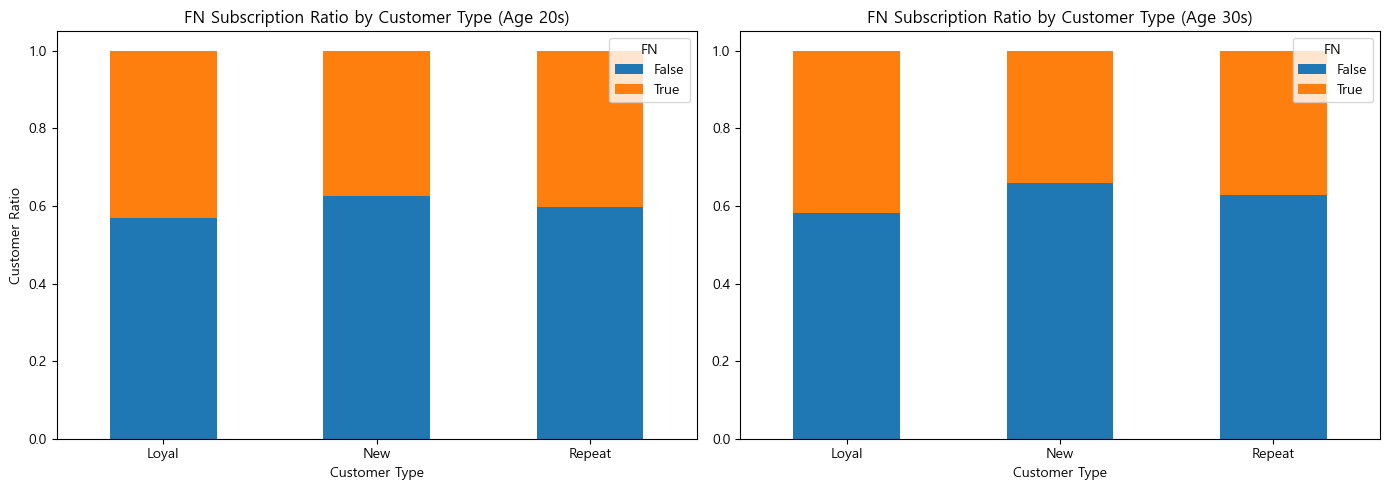

In [49]:
plt.figure(figsize=(14, 5))

# ===== 20대 =====
plt.subplot(1, 2, 1)

fn_20s.plot(
    kind="bar",
    stacked=True,
    ax=plt.gca()
)

plt.title("FN Subscription Ratio by Customer Type (Age 20s)")
plt.xlabel("Customer Type")
plt.ylabel("Customer Ratio")
plt.xticks(rotation=0)
plt.legend(title="FN")


# ===== 30대 =====
plt.subplot(1, 2, 2)

fn_30s.plot(
    kind="bar",
    stacked=True,
    ax=plt.gca()
)

plt.title("FN Subscription Ratio by Customer Type (Age 30s)")
plt.xlabel("Customer Type")
plt.xticks(rotation=0)
plt.legend(title="FN")


plt.tight_layout()
plt.show()

In [50]:
print("20대 누적고객과 FN관계")
print(fn_20s)
print("\n 30대 누적고객과 FN관계")
print(fn_30s)

20대 누적고객과 FN관계
FN                False     True 
customer_type                    
Loyal          0.568368  0.431632
New            0.625358  0.374642
Repeat         0.596938  0.403062

 30대 누적고객과 FN관계
FN                False     True 
customer_type                    
Loyal          0.581566  0.418434
New            0.659652  0.340348
Repeat         0.627216  0.372784


#### 고객 타입 X 특정 나이대(20~30대) X 맴버십

In [51]:
member_dist = (
    target_2030
    .groupby(["age_group", "customer_type", "club_member_status"])
    .size()
    .reset_index(name="customer_cnt")
)

member_dist["ratio"] = (
    member_dist["customer_cnt"]
    / member_dist
        .groupby(["age_group", "customer_type"])["customer_cnt"]
        .transform("sum")
)

member_pivot = (
    member_dist
    .pivot(
        index=["age_group", "customer_type"],
        columns="club_member_status",
        values="ratio"
    )
    .fillna(0)
)

member_20s = member_pivot.loc["20s"]
member_30s = member_pivot.loc["30s"]

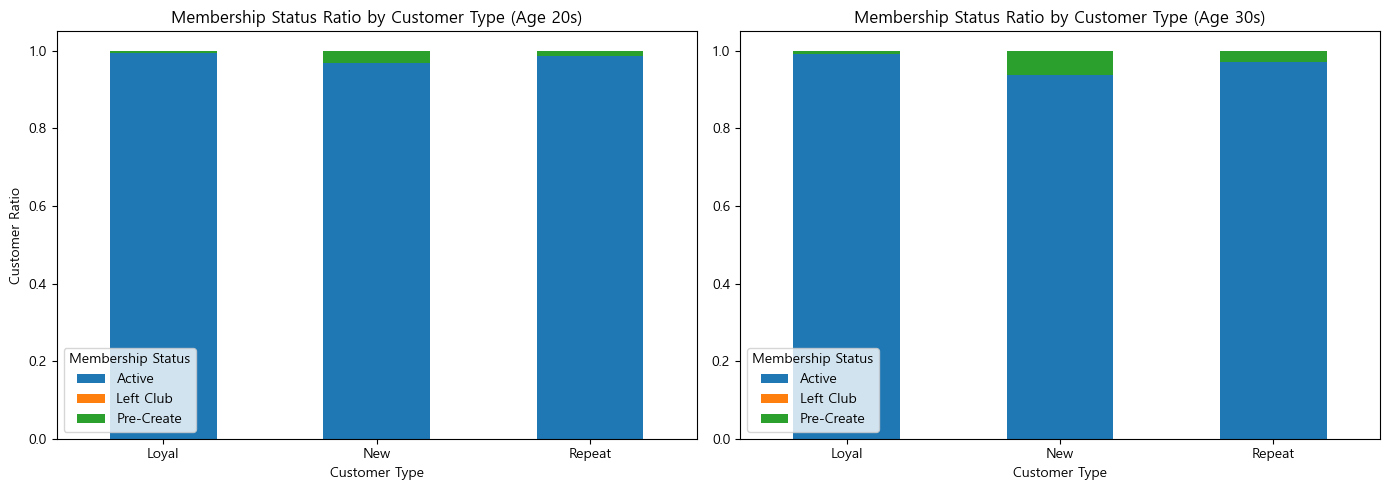

In [52]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
member_20s.plot(kind="bar", stacked=True, ax=plt.gca())
plt.title("Membership Status Ratio by Customer Type (Age 20s)")
plt.xlabel("Customer Type")
plt.ylabel("Customer Ratio")
plt.xticks(rotation=0)
plt.legend(title="Membership Status")

plt.subplot(1, 2, 2)
member_30s.plot(kind="bar", stacked=True, ax=plt.gca())
plt.title("Membership Status Ratio by Customer Type (Age 30s)")
plt.xlabel("Customer Type")
plt.xticks(rotation=0)
plt.legend(title="Membership Status")

plt.tight_layout()
plt.show()

In [53]:
print("20대 누적고객과 맴버십 관계")
print(member_20s)
print("\n 30대 누적고객과 맴버십 관계")
print(member_30s)

20대 누적고객과 맴버십 관계
club_member_status    Active  Left Club  Pre-Create
customer_type                                      
Loyal               0.995030   0.000376    0.004594
New                 0.969346   0.000279    0.030375
Repeat              0.985250   0.000322    0.014428

 30대 누적고객과 맴버십 관계
club_member_status    Active  Left Club  Pre-Create
customer_type                                      
Loyal               0.990386   0.000534    0.009080
New                 0.937731   0.000429    0.061839
Repeat              0.970267   0.000402    0.029332


#### 고객 타입 X 특정 나이대(20~30대) X 상위20%, 하위20%

In [54]:
revenue_dist = (
    target_2030
    .groupby(["age_group", "customer_type", "revenue_group"])
    .size()
    .reset_index(name="customer_cnt")
)

revenue_dist["ratio"] = (
    revenue_dist["customer_cnt"]
    / revenue_dist
        .groupby(["age_group", "customer_type"])["customer_cnt"]
        .transform("sum")
)

revenue_pivot = (
    revenue_dist
    .pivot(
        index=["age_group", "customer_type"],
        columns="revenue_group",
        values="ratio"
    )
    .fillna(0)
)

revenue_20s = revenue_pivot.loc["20s"]
revenue_30s = revenue_pivot.loc["30s"]


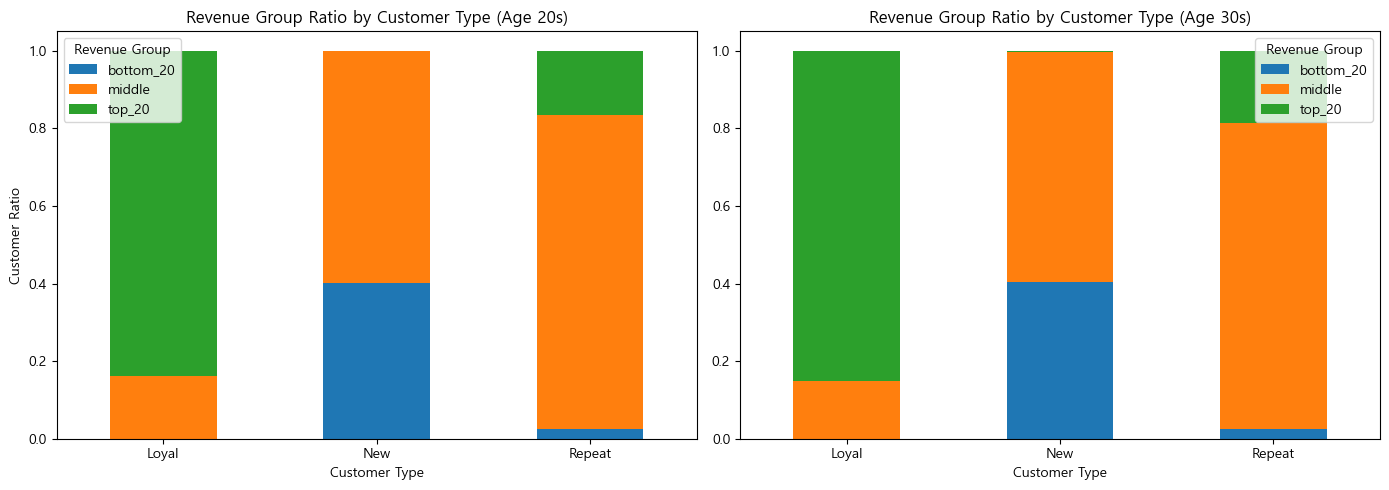

In [55]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
revenue_20s.plot(kind="bar", stacked=True, ax=plt.gca())
plt.title("Revenue Group Ratio by Customer Type (Age 20s)")
plt.xlabel("Customer Type")
plt.ylabel("Customer Ratio")
plt.xticks(rotation=0)
plt.legend(title="Revenue Group")

plt.subplot(1, 2, 2)
revenue_30s.plot(kind="bar", stacked=True, ax=plt.gca())
plt.title("Revenue Group Ratio by Customer Type (Age 30s)")
plt.xlabel("Customer Type")
plt.xticks(rotation=0)
plt.legend(title="Revenue Group")

plt.tight_layout()
plt.show()

In [56]:
print("20대 누적고객과 상하위 매출군 관계")
print(revenue_20s)
print("\n 30대 누적고객과 상하위 매출군 관계")
print(revenue_30s)

20대 누적고객과 상하위 매출군 관계
revenue_group  bottom_20    middle    top_20
customer_type                               
Loyal           0.000167  0.161544  0.838289
New             0.401248  0.597342  0.001410
Repeat          0.024275  0.809601  0.166124

 30대 누적고객과 상하위 매출군 관계
revenue_group  bottom_20    middle    top_20
customer_type                               
Loyal           0.000305  0.147871  0.851824
New             0.403673  0.594080  0.002246
Repeat          0.024867  0.787982  0.187151


## 상품군별 분석

In [57]:
customer_summary.columns

Index(['customer_id', 'transaction_cnt', 'age_group', 'FN',
       'club_member_status', 'Active', 'revenue_group', 'customer_type'],
      dtype='str')

In [58]:
cust_type = customer_summary[
    ["customer_id", 
    "customer_type", 
    "age_group", 
    "FN", 
    "club_member_status", 
    "Active", 
    "revenue_group"]
].copy()

cust_type.isna().sum()

customer_id           0
customer_type         0
age_group             0
FN                    0
club_member_status    0
Active                0
revenue_group         0
dtype: int64

In [59]:
# 거래x상품 테이블 조인
tx_art = (
    analysis_cust[
        ["t_dat", 
        "year_month", 
        "customer_id", 
        "article_id", 
        "revenue", 
        "sales_channel_id"]
    ]
    .merge(
        art,
        on="article_id",
        how="left"
    )
)
tx_art.isna().sum()

t_dat                           0
year_month                      0
customer_id                     0
article_id                      0
revenue                         0
sales_channel_id                0
product_code                    0
prod_name                       0
product_type_info               0
product_group_name              0
graphical_appearance_info       0
perceived_colour_master_info    0
department_info                 0
index_info                      0
index_group_info                0
section_info                    0
garment_group_info              0
dtype: int64

In [60]:
# tx_art_cust + cust_type
tx_art_cust = (
    tx_art
    .merge(
        cust_type,
        on="customer_id",
        how="left"
    )
)

tx_art_cust.shape

(804149, 23)

In [61]:
tx_art_cust.isna().sum()

t_dat                           0
year_month                      0
customer_id                     0
article_id                      0
revenue                         0
sales_channel_id                0
product_code                    0
prod_name                       0
product_type_info               0
product_group_name              0
graphical_appearance_info       0
perceived_colour_master_info    0
department_info                 0
index_info                      0
index_group_info                0
section_info                    0
garment_group_info              0
customer_type                   0
age_group                       0
FN                              0
club_member_status              0
Active                          0
revenue_group                   0
dtype: int64

In [62]:
# 20~30대 나이대 필터링
tx_2030 = tx_art_cust[
    tx_art_cust["age_group"].isin(["20s", "30s"])
].copy()

### 고객 타입 X 특정 나이대(20~30대) X 상품군

In [63]:
prod_dist = (
    tx_2030
    .groupby(["age_group", "customer_type", "product_group_name"])
    .size()
    .reset_index(name="purchase_cnt")
)

prod_dist["ratio"] = (
    prod_dist["purchase_cnt"]
    / prod_dist
        .groupby(["age_group", "customer_type"])["purchase_cnt"]
        .transform("sum")
)

top5_products = (
    prod_dist
    .groupby("product_group_name")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

prod_top5 = prod_dist[
    prod_dist["product_group_name"].isin(top5_products)
].copy()

prod_pivot = (
    prod_top5
    .pivot(
        index=["age_group", "customer_type"],
        columns="product_group_name",
        values="ratio"
    )
    .fillna(0)
)

prod_pivot = prod_pivot.loc[
    prod_pivot.sum(axis=1).sort_values(ascending=False).index
]

prod_20s = prod_pivot.loc["20s"]
prod_30s = prod_pivot.loc["30s"]

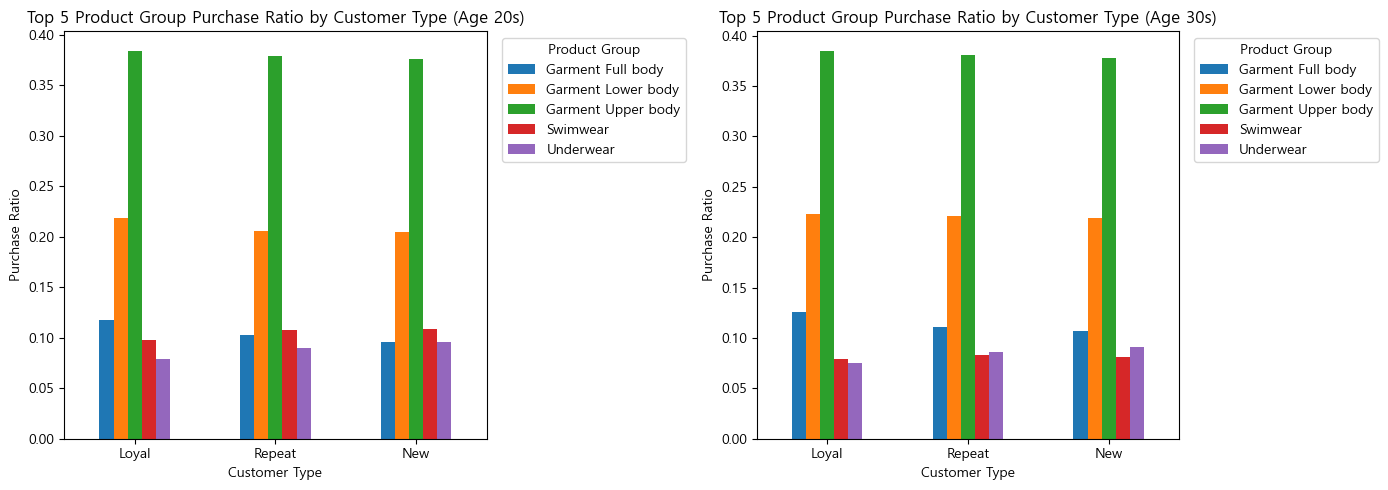

product_group_name       Garment Full body  Garment Lower body  \
age_group customer_type                                          
20s       Loyal                   0.117807            0.218580   
30s       Loyal                   0.125605            0.223404   
20s       Repeat                  0.102389            0.205940   
          New                     0.095884            0.204651   
30s       Repeat                  0.110470            0.220561   
          New                     0.107030            0.219014   

product_group_name       Garment Upper body  Swimwear  Underwear  
age_group customer_type                                           
20s       Loyal                    0.384109  0.097286   0.078571  
30s       Loyal                    0.385080  0.079096   0.075563  
20s       Repeat                   0.379163  0.108039   0.089561  
          New                      0.375815  0.109075   0.096135  
30s       Repeat                   0.380899  0.082967   0.085888  
          New                      0.377841  0.080999   0.091305

In [64]:
plt.figure(figsize=(14, 5))

# ===== 20대 =====
plt.subplot(1, 2, 1)

prod_20s.plot(
    kind="bar",
    ax=plt.gca()
)

plt.title("Top 5 Product Group Purchase Ratio by Customer Type (Age 20s)")
plt.xlabel("Customer Type")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=0)
plt.legend(title="Product Group", bbox_to_anchor=(1.02, 1), loc="upper left")

# ===== 30대 =====
plt.subplot(1, 2, 2)

prod_30s.plot(
    kind="bar",
    ax=plt.gca()
)

plt.title("Top 5 Product Group Purchase Ratio by Customer Type (Age 30s)")
plt.xlabel("Customer Type")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=0)
plt.legend(title="Product Group", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

prod_pivot

### 고객 타입 x 20~30대 x garment_group_info

In [65]:
garment_dist = (
    tx_2030
    .groupby(["age_group", "customer_type", "garment_group_info"])
    .size()
    .reset_index(name="purchase_cnt")
)

garment_dist["ratio"] = (
    garment_dist["purchase_cnt"]
    / garment_dist
        .groupby(["age_group", "customer_type"])["purchase_cnt"]
        .transform("sum")
)
# top5 선정 
top5_garments = (
    garment_dist
    .groupby("garment_group_info")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

garment_top5 = garment_dist[
    garment_dist["garment_group_info"].isin(top5_garments)
].copy()


garment_pivot = (
    garment_top5
    .pivot(
        index=["age_group", "customer_type"],
        columns="garment_group_info",
        values="ratio"
    )
    .fillna(0)
)

garment_pivot = garment_pivot.loc[
    garment_pivot.sum(axis=1).sort_values(ascending=False).index
]

garment_20s = garment_pivot.loc["20s"]
garment_30s = garment_pivot.loc["30s"]

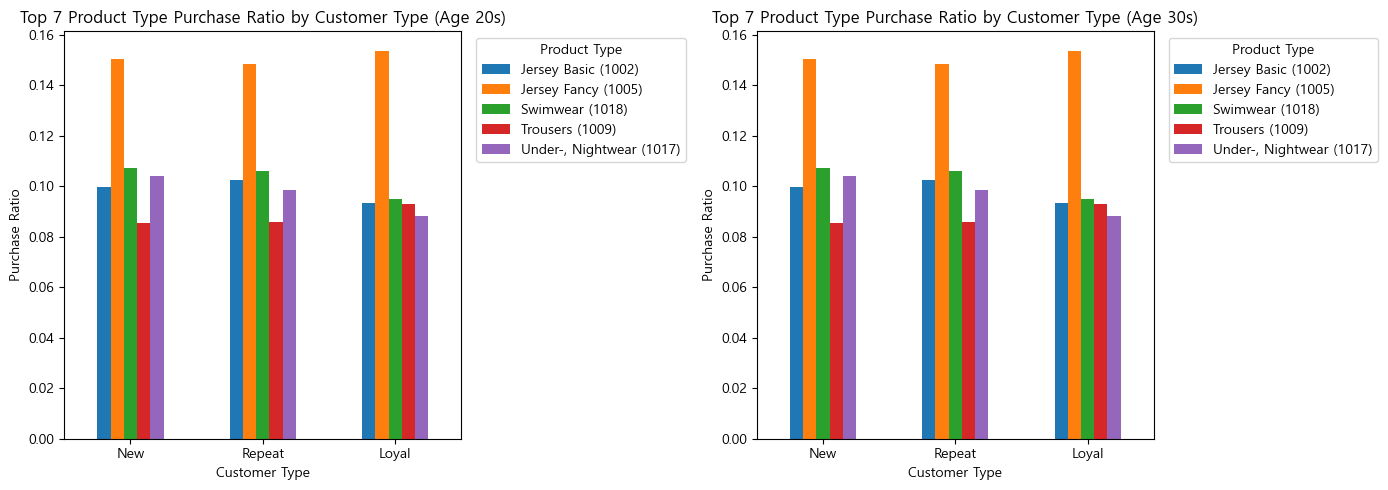

In [66]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)

# ===== 20대 =====
plt.subplot(1, 2, 1)

garment_20s.plot(
    kind="bar",
    ax=plt.gca()
)

plt.title("Top 7 Product Type Purchase Ratio by Customer Type (Age 20s)")
plt.xlabel("Customer Type")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=0)
plt.legend(title="Product Type", bbox_to_anchor=(1.02, 1), loc="upper left")

# ===== 30대 =====
plt.subplot(1, 2, 2)

garment_20s.plot(
    kind="bar",
    ax=plt.gca()
)

plt.title("Top 7 Product Type Purchase Ratio by Customer Type (Age 30s)")
plt.xlabel("Customer Type")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=0)
plt.legend(title="Product Type", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

### 고객 타입 x 20~30대 x product_type_info

In [67]:
type_dist = (
    tx_2030
    .groupby(["age_group", "customer_type", "product_type_info"])
    .size()
    .reset_index(name="purchase_cnt")
)

type_dist["ratio"] = (
    type_dist["purchase_cnt"]
    / type_dist
        .groupby(["age_group", "customer_type"])["purchase_cnt"]
        .transform("sum")
)

top7_types = (
    type_dist
    .groupby("product_type_info")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(7)
    .index
)

type_top7 = type_dist[
    type_dist["product_type_info"].isin(top7_types)
].copy()


type_pivot = (
    type_top7
    .pivot(
        index=["age_group", "customer_type"],
        columns="product_type_info",
        values="ratio"
    )
    .fillna(0)
)

type_pivot = type_pivot.loc[
    type_pivot.sum(axis=1).sort_values(ascending=False).index
]

type_20s = type_pivot.loc["20s"]
type_30s = type_pivot.loc["30s"]

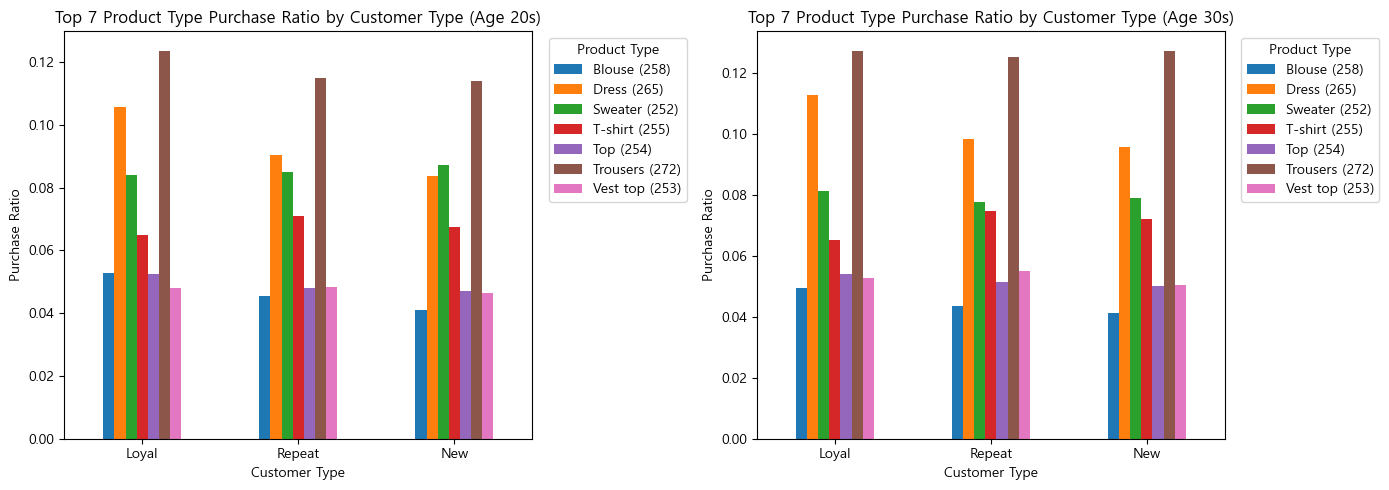

In [68]:
plt.figure(figsize=(14, 5))

# ===== 20대 =====
plt.subplot(1, 2, 1)

type_20s.plot(
    kind="bar",
    ax=plt.gca()
)

plt.title("Top 7 Product Type Purchase Ratio by Customer Type (Age 20s)")
plt.xlabel("Customer Type")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=0)
plt.legend(title="Product Type", bbox_to_anchor=(1.02, 1), loc="upper left")

# ===== 30대 =====
plt.subplot(1, 2, 2)

type_30s.plot(
    kind="bar",
    ax=plt.gca()
)

plt.title("Top 7 Product Type Purchase Ratio by Customer Type (Age 30s)")
plt.xlabel("Customer Type")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=0)
plt.legend(title="Product Type", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()